### Forward Stochastic Differential Equation (Forward SDE)

A general forward stochastic differential equation (SDE) has the form:

$$
dx_t = f(x_t, t)\,DT + g(t)\,dW_t
\qquad x_0 \sim p_0(x)
$$

where:

- $x_t \in \mathbb{R}^d$ is the state at time $t$  
- $f(x,t)$ is the **drift** term (deterministic dynamics)  
- $g(t)$ is the **diffusion coefficient** (noise strength)  
- $dW_t$ is standard Brownian motion  

The forward SDE describes how a distribution evolves over time by:

1. Deterministic motion through the drift $f(x,t)$  
2. Random perturbations through the noise term $g(t)\,dW_t$

As time increases, noise is injected into the system and the distribution evolves from
$p_0(x)$ toward a simpler distribution (often Gaussian).

---

### Reverse Stochastic Differential Equation (Reverse SDE)

The reverse process aims to generate samples from $p_0(x)$ starting from a simple distribution at time $T$.

$$
dx_t =
\Big[
f(x_t, t)
-
g(t)^2 \nabla_x \log p_t(x_t)
\Big] DT
+
g(t)\, d\bar{W}_t
$$

where:

- $\nabla_x \log p_t(x)$ is the **score function**
- $d\bar{W}_t$ is Brownian motion in reverse time
- The drift is modified by the score term


The additional term

$$
- g(t)^2 \nabla_x \log p_t(x)
$$

corrects for the noise injected during the forward process. The score function tells us **in which 
direction probability increases most steeply**.

---

### Probability Flow ODE

There is also a deterministic counterpart:

$$
dx_t =
\Big[
f(x_t, t)
-
\frac{1}{2} g(t)^2 \nabla_x \log p_t(x_t)
\Big] DT
$$

This ODE has the same marginal distributions as the reverse SDE but produces deterministic trajectories.

---

### Example 1: Ornstein–Uhlenbeck (OU) Process

Consider the 1D Ornstein–Uhlenbeck process:

$$
dx_t = -\lambda x_t\,DT + \sigma\,dW_t,
\qquad x_0 \sim \mathcal{N}(\mu_0, \sigma_0^2)
$$

This is a linear SDE, so the solution remains Gaussian for all time:

$$
x_t \sim \mathcal{N}(\mu_t, v(t))
$$

The evolution of mean and variance:

$$
\mu_t = \mathbb{E}[x_t] = \mu_0 e^{-\lambda t}
$$

$$
v(t)
=
\sigma_0^2 e^{-2\lambda t}
+
\frac{\sigma^2}{2\lambda}
\left(1 - e^{-2\lambda t}\right)
$$

Since the distribution is Gaussian the score (gradient of the log-density) is:

$$
s(x,t)
=
\nabla_x \log p_t(x)
=
-\frac{x - \mu_t}{v(t)}
$$

---

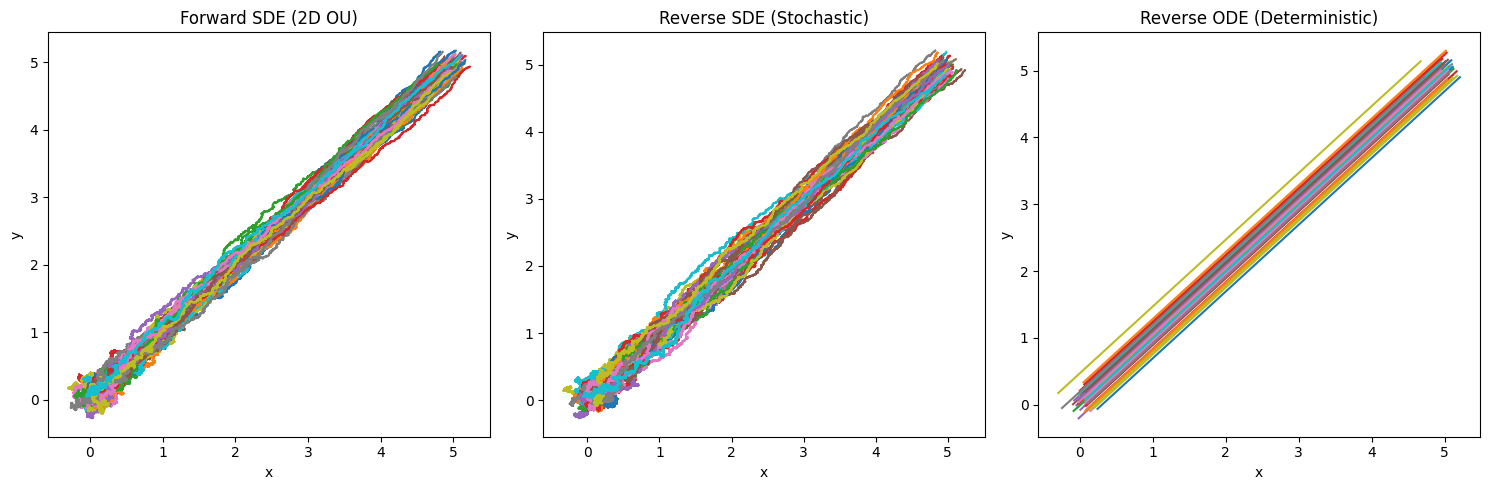

In [241]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Parameters
# ----------------------------
DT = 0.001
T = 10.0
STEPS = int(T / DT)
N_PARTICLES = 50
MEAN_0 = 5.0
STD_DEV_0 = 0.1
LAMBDA = 0.5
SIGMA = 0.1

# ----------------------------
# 1. Forward SDE Simulation
# ----------------------------
x_forward = np.zeros((STEPS, N_PARTICLES, 2))
x_forward[0] = np.random.normal(MEAN_0, STD_DEV_0, (N_PARTICLES, 2))

for t in range(1, STEPS):
    dw = np.random.normal(0, np.sqrt(DT), (N_PARTICLES, 2))
    drift = -LAMBDA * x_forward[t-1]
    diffusion = SIGMA * dw
    x_forward[t] = x_forward[t-1] + drift*DT + diffusion

# ----------------------------
# 2. Score function with time-dependent mean
# ----------------------------
def get_score(x, t):
    """Analytical score for OU with initial mean 5"""
    mu_t = MEAN_0 * np.exp(-LAMBDA * t)  # decaying mean
    v = (
        STD_DEV_0**2 * np.exp(-2 * LAMBDA * t)
        + (SIGMA**2 / (2 * LAMBDA)) * (1 - np.exp(-2 * LAMBDA * t))
    )
    return -(x - mu_t) / (v + 1e-8)

# ----------------------------
# 3a. Reverse SDE (stochastic)
# ----------------------------
x_reverse_sde = np.zeros((STEPS, N_PARTICLES, 2))
x_reverse_sde[0] = x_forward[-1]

for i in range(1, STEPS):
    t = T - i*DT
    curr_x = x_reverse_sde[i-1]
    score = get_score(curr_x, t)
    drift = (-LAMBDA * curr_x) - (SIGMA**2 * score)
    dw = np.random.normal(0, np.sqrt(DT), (N_PARTICLES, 2))
    x_reverse_sde[i] = curr_x - drift*DT + SIGMA*dw

# ----------------------------
# 3b. Reverse ODE (deterministic probability flow)
# ----------------------------
x_reverse_ode = np.zeros((STEPS, N_PARTICLES, 2))
x_reverse_ode[0] = x_forward[-1]

for i in range(1, STEPS):
    t = T - i*DT
    curr_x = x_reverse_ode[i-1]
    score = get_score(curr_x, t)
    drift = (-LAMBDA * curr_x) - 0.5 * (SIGMA**2) * score
    x_reverse_ode[i] = curr_x - drift*DT  # no stochastic term

# ----------------------------
# 4. Plotting
# ----------------------------
plt.figure(figsize=(15, 5))

# Forward trajectories
plt.subplot(1, 3, 1)
for p in range(N_PARTICLES):
    plt.plot(x_forward[:, p, 0], x_forward[:, p, 1])
plt.title("Forward SDE (2D OU)")
plt.xlabel("x")
plt.ylabel("y")

# Stochastic reverse
plt.subplot(1, 3, 2)
for p in range(N_PARTICLES):
    plt.plot(x_reverse_sde[:, p, 0], x_reverse_sde[:, p, 1])
plt.title("Reverse SDE (Stochastic)")
plt.xlabel("x")
plt.ylabel("y")

# Deterministic reverse ODE
plt.subplot(1, 3, 3)
for p in range(N_PARTICLES):
    plt.plot(x_reverse_ode[:, p, 0], x_reverse_ode[:, p, 1])
plt.title("Reverse ODE (Deterministic)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()


### Connection to Difussion Models

In most practical problems, $p_t(x)$ is unknown.
Therefore, diffusion models train a neural network:

$$
s_\theta(x,t) \approx \nabla_x \log p_t(x)
$$

This learned score replaces the analytical expression in the reverse SDE and probability flow ODE. 
In diffusion models:

- The forward SDE gradually transforms data distribution $p_0(x)$
- As $t \to T$, $p_T(x)$ becomes a simple distribution (usually Gaussian)
- The reverse process learns how to invert this trans

---

### Example 2:

...

100%|██████████| 50000/50000 [00:45<00:00, 1101.70it/s]


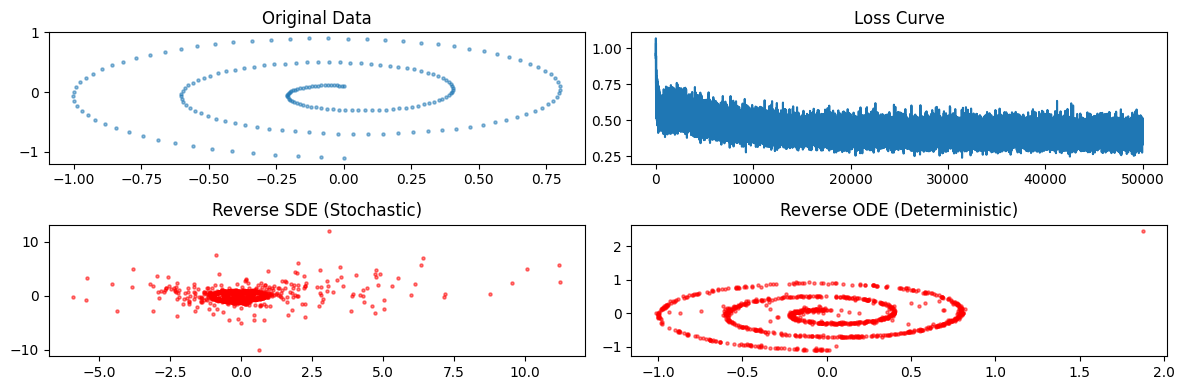

In [ ]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from itertools import pairwise
from tqdm import tqdm

# ----------------------------
# Swiss Roll Dataset (2D)
# ----------------------------
class Swissroll:
    def __init__(self, tmin, tmax, N, center=(0,0), scale=1.0):
        t = tmin + torch.linspace(0, 1, N) * tmax
        center = torch.tensor(center).unsqueeze(0)
        self.vals = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T

    def __len__(self):
        return len(self.vals)

    def __getitem__(self, i):
        return self.vals[i]

# ----------------------------
# Noise Schedule
# ----------------------------
class ScheduleLogLinear:
    def __init__(self, N: int, sigma_min: float, sigma_max: float):
        self.sigmas = torch.logspace(np.log10(sigma_min), np.log10(sigma_max), N)

    def sample_batch(self, n):
        idx = torch.randint(0, len(self.sigmas), (n,))
        return self.sigmas[idx].unsqueeze(1)  # shape (n,1)

# ----------------------------
# MLP
# ----------------------------
class MLP(nn.Module):
    def __init__(self, dim: int, sigma_dim: int, hidden_dims: tuple):
        super().__init__()
        layers = []
        for in_dim, out_dim in pairwise((dim + sigma_dim,) + hidden_dims):
            layers.extend([nn.Linear(in_dim, out_dim), nn.GELU()])
        layers.append(nn.Linear(hidden_dims[-1], dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, sigma):
        nn_input = torch.cat([x, sigma], dim=1)
        return self.net(nn_input)

# ----------------------------
# Parameters
# ----------------------------
DEVICE = "cpu"
BATCH_SIZE = 200
EPOCHS = 50000
LR = 1e-3

# ----------------------------
# Dataset
# ----------------------------
dataset = Swissroll(np.pi/2, 5*np.pi, BATCH_SIZE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# Training
# ----------------------------
model = MLP(dim=2, sigma_dim=1, hidden_dims=(16,128,128,128,16)).to(DEVICE)
schedule = ScheduleLogLinear(N=256, sigma_min=0.01, sigma_max=10.0)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_func = nn.MSELoss()

losses = []

for _ in tqdm(range(EPOCHS)):
    for x0 in loader:
        x0 = x0.to(DEVICE)

        eps = torch.randn_like(x0)
        sigma = schedule.sample_batch(x0.shape[0]).to(DEVICE)

        noised_data = x0 + sigma * eps

        yhat = model(noised_data, sigma)
        loss = loss_func(eps, yhat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

# ----------------------------
# Inference Reverse SDE
# ----------------------------
model.eval()
sigmas = schedule.sigmas.flip(0).to(DEVICE)
with torch.no_grad():
    xt_reverse_sde = torch.randn(1000, 2).to(DEVICE) * sigmas[0]
    for sig, sig_prev in pairwise(sigmas):
        # Predict noise
        eps_theta = model(xt_reverse_sde, sig.expand(xt_reverse_sde.shape[0], 1))
        # Compensate noise
        noise = torch.randn_like(xt_reverse_sde)
        drift = (sig_prev - sig) * eps_theta
        diffusion = torch.sqrt(sig**2 - sig_prev**2) * noise
        xt_reverse_sde = xt_reverse_sde + drift + diffusion

# ----------------------------
# Inference ODE
# ----------------------------
model.eval()
sigmas = schedule.sigmas.flip(0).to(DEVICE)
with torch.no_grad():
    xt_reverse_ode = torch.randn(1000, 2).to(DEVICE) * sigmas[0]
    for sig, sig_prev in pairwise(sigmas):
        # Predict noise
        eps_theta = model(xt_reverse_ode, sig.expand(xt_reverse_ode.shape[0], 1))
        # Compensate noise
        xt_reverse_ode = xt_reverse_ode + (sig_prev - sig) * eps_theta

# ----------------------------
# Plotting Results
# ----------------------------
plt.figure(figsize=(12, 4))

plt.subplot(2, 2, 1)
plt.title("Original Data")
plt.scatter(dataset.vals[:, 0], dataset.vals[:, 1], s=5, alpha=0.5)

plt.subplot(2, 2, 2)
plt.title("Loss Curve")
plt.plot(losses)

plt.subplot(2, 2, 3)
plt.title("Reverse SDE (Stochastic)")
plt.scatter(xt_reverse_sde[:, 0].cpu(), xt_reverse_sde[:, 1].cpu(), s=5, color="red", alpha=0.5)

plt.subplot(2, 2, 4)
plt.title("Reverse ODE (Deterministic)")
plt.scatter(xt_reverse_ode[:, 0].cpu(), xt_reverse_ode[:, 1].cpu(), s=5, color="red", alpha=0.5)

plt.tight_layout()
plt.show()
